In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega
import seaborn as sns
# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text
con= create_engine('postgresql://eicu@192.168.60.144:6432/eicu')

In [2]:
datadir = '/home/mei/nas/docker/dataset/EICU/eicu-collaborative-research-database-2.0/'
porcesseddir2 = '/home/mei/nas/docker/processedData_2/'

## 筛选出病人来自 direct 和 emergency 并且 住icu时长为 1到14天的病人

In [5]:
create_table_patient = query_schema + """

DROP TABLE IF EXISTS patient_2 CASCADE;
CREATE TABLE patient_2 as
SELECT DISTINCT patientunitstayid, hospitaladmitOffset, gender, age, apacheadmissiondx, unitadmitsource, admissionweight,	dischargeweight, unitdischargeoffset, unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
    AND unitdischargeoffset >=1440 
    AND unitdischargeoffset <=20160
group by patientunitstayid, hospitaladmitOffset
order by patientunitstayid, hospitaladmitOffset
      
"""
# df_p = pd.read_sql_query(query, con)

In [15]:
# with con.begin() as connection:
#     connection.execute(text(create_table_patient))  # Use text() to wrap the raw SQL

patient_2 = "SELECT * FROM patient_2;"
df_patient = pd.read_sql_query(text(patient_2),con)

In [16]:
df_patient.head(n=20)

,patientunitstayid,hospitaladmitoffset,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus
0,141168,0,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,3596,Death,Expired
1,141265,-1,Male,67,"CVA, cerebrovascular accident/stroke",Direct Admit,100.0,91.8,6068,Floor,Alive
2,141266,-18,Male,73,"Sepsis, renal/UTI (including bladder)",Emergency Department,120.4,112.9,1501,Floor,Alive
3,141276,-1,Female,59,"Arrest, respiratory (without cardiac arrest)",Direct Admit,156.6,156.6,1684,Home,Alive
4,141284,-15,Male,63,Anemia,Direct Admit,NaN,88.5,2076,Floor,Alive
5,141288,-171,Female,61,"Sepsis, pulmonary",Emergency Department,NaN,92.2,1631,Floor,Alive
6,141304,-3,Male,70,"Sepsis, pulmonary",Emergency Department,NaN,68.0,6639,Floor,Alive
7,141329,-87,Male,50,"Infarction, acute myocardial (MI)",Direct Admit,79.0,79.3,2572,Floor,Alive
8,141360,-30,Male,48,"CVA, cerebrovascular accident/stroke",Emergency Department,NaN,92.3,3109,Floor,Alive
9,141415,-347,Male,30,"Thrombosis, vascular (deep vein)",Direct Admit,87.1,86.7,4430,Floor,Alive


In [18]:
# df_patient.to_csv(porcesseddir2 + 'selected_patient.csv',  index=False)

In [19]:
n =df_patient['patientunitstayid'].nunique()
print("There are {} unique patientunitstayid patients from the unitadmitsource: emergency and direct with a stay length between 1 and 14 days.".format(n))

There are 68446 unique patientunitstayid patients from the unitadmitsource: emergency and direct with a stay length between 1 and 14 days.


In [20]:
df_p=df_patient.copy()


In [21]:

frequency_table =df_p.groupby(['unitdischargelocation', 'unitdischargestatus']).size().reset_index(name='count')
print(frequency_table)


       unitdischargelocation unitdischargestatus  count
0                                                     4
1                                          Alive     66
2           Acute Care/Floor               Alive   6725
3                      Death             Expired   3452
4                      Floor               Alive  33902
5                       Home               Alive   6909
6                        ICU               Alive    216
7               Nursing Home               Alive    135
8             Operating Room               Alive      4
9                      Other               Alive    530
10            Other External               Alive   1122
11            Other Hospital               Alive   1250
12                 Other ICU               Alive   1045
13          Other ICU (CABG)               Alive      3
14            Other Internal               Alive     98
15            Rehabilitation               Alive    219
16  Skilled Nursing Facility               Alive

- Home：恢复最好
- Floor、Rehabilitation、Acute Care/Floor：表示病情有所好转。
- Step-Down Unit (SDU)、Skilled Nursing Facility、Other：患者需要监护，情况相对中等。
- ICU、Operating Room、Other ICU，Other ICU (CABG)：病情较为严重。
- Death 最严重的情况。

## 统计 nan 值

In [22]:
missing_ratio = pd.DataFrame(df_p.isna().sum() / len(df_p.index), columns = ['missing ratio %']) * 100
missing_ratio.sort_values('missing ratio %', inplace = True, ascending = False) 
missing_ratio

,missing ratio %
dischargeweight,38.985478
admissionweight,2.023493
patientunitstayid,0.000000
hospitaladmitoffset,0.000000
gender,0.000000
age,0.000000
apacheadmissiondx,0.000000
unitadmitsource,0.000000
unitdischargeoffset,0.000000
unitdischargelocation,0.000000


In [18]:
freq_l = pd.DataFrame()
freq_l['noAnnotations'] = df_p['unitdischargelocation'].value_counts() 
freq_l['%'] = df_p['unitdischargelocation'].value_counts() / len(df_p.index) * 100
freq_l

,noAnnotations,%
unitdischargelocation,,
Floor,33902,49.531017
Step-Down Unit (SDU),7617,11.128481
Home,6909,10.094089
Acute Care/Floor,6725,9.825264
Telemetry,4325,6.318850
Death,3452,5.043392
Other Hospital,1250,1.826257
Other External,1122,1.639248
Other ICU,1045,1.526751


In [23]:
freq_s = pd.DataFrame()
freq_s['noAnnotations'] = df_p['unitdischargestatus'].value_counts() 
freq_s['%'] = df_p['unitdischargestatus'].value_counts() / len(df_p.index) * 100
freq_s

,noAnnotations,%
unitdischargestatus,,
Alive,64990,94.950764
Expired,3452,5.043392
,4,0.005844


## analysis the relation between unitdischargelocation', 'unitdischargeoffset' and risk sore

In [24]:
cols=[ 'patientunitstayid', 'unitdischargeoffset','unitdischargelocation']
df_p1=df_p[cols]

In [3]:
# df_p1.to_csv(porcesseddir2 + 'selected_patient_relation_function.csv',index=False)

df_p1=pd.read_csv(porcesseddir2 + 'selected_patient_relation_function.csv',index_col=False)


In [4]:
df_p1.head()

,patientunitstayid,unitdischargeoffset,unitdischargelocation
0,141168,3596,Death
1,141265,6068,Floor
2,141266,1501,Floor
3,141276,1684,Home
4,141284,2076,Floor


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [11]:
def classify_discharge_location(location):
    high_risk = ['ICU', 'Other ICU', 'Other ICU (CABG)', 'Step-Down Unit (SDU)', 'Operating Room']
    medium_risk = ['Acute Care/Floor', 'Floor', 'Telemetry', 'Other Hospital', 'Other External', 'Rehabilitation', 'Other Internal']
    low_risk = ['Nursing Home', 'Skilled Nursing Facility', 'Home']
    death = ['Death']
    
    if location in high_risk:
        return 'High Risk'
    elif location in medium_risk:
        return 'Medium Risk'
    elif location in low_risk:
        return 'Low Risk'
    elif location in death:
        return 'Death'
    else:
        return 'Unknown'

# 应用分类
df_p1['discharge_risk_category'] = df_p1['unitdischargelocation'].apply(classify_discharge_location)

# 检查分类结果
print(df_p1[['unitdischargelocation', 'discharge_risk_category']].head())

  unitdischargelocation discharge_risk_category
0                 Death                   Death
1                 Floor             Medium Risk
2                 Floor             Medium Risk
3                  Home                Low Risk
4                 Floor             Medium Risk


In [44]:
def calculate_risk(row):
    # 根据unitdischargelocation设定基础的风险
    if row['discharge_risk_category'] == 'Death':
        base_risk = 100  # 高风险
    elif row['discharge_risk_category'] == 'High Risk':
        base_risk = 80
    elif row['discharge_risk_category'] == 'Low Risk':
        base_risk = 10   # 低风险
    elif row['discharge_risk_category'] == 'Medium Risk':
        base_risk = 50   # 中等风险
    else:
        base_risk = 30   # 其他位置风险较中等

    # 通过unitdischargeoffset来调整风险分数，住院时间越长风险越高
    offset_adjustment = row['unitdischargeoffset'] / 1000  # 简单线性调整

    # 计算最终风险分数
    risk_score = base_risk + offset_adjustment
    return risk_score

# 应用规则生成 proxy risk score
df_p1['risk_score'] = df_p1.apply(calculate_risk, axis=1)

# 检查结果
print(df_p1[['patientunitstayid', 'unitdischargelocation', 'unitdischargeoffset', 'discharge_risk_category','risk_score']].head())

   patientunitstayid unitdischargelocation  unitdischargeoffset  \
0             141168                 Death                 3596   
1             141265                 Floor                 6068   
2             141266                 Floor                 1501   
3             141276                  Home                 1684   
4             141284                 Floor                 2076   

  discharge_risk_category  risk_score  
0                   Death     103.596  
1             Medium Risk      56.068  
2             Medium Risk      51.501  
3                Low Risk      11.684  
4             Medium Risk      52.076  


In [45]:
label_encoder=LabelEncoder()
df_p1['unitdischargelocation_encoded'] = label_encoder.fit_transform(df_p1['discharge_risk_category'])
X = df_p1[['unitdischargeoffset', 'unitdischargelocation_encoded']]
y = df_p1['risk_score']


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 预测
y_pred = rf_model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
print("均方误差：", mse)

# 输出部分预测结果
df_test_results = X_test.copy()
df_test_results['predicted_risk_score'] = y_pred
df_test_results.head()



均方误差： 0.0001017046641417147


,unitdischargeoffset,unitdischargelocation_encoded,predicted_risk_score
28763,3986,3,53.98599
63499,1612,3,51.61200
29223,7152,0,107.15008
15191,4329,3,54.32887
55000,4486,3,54.48599


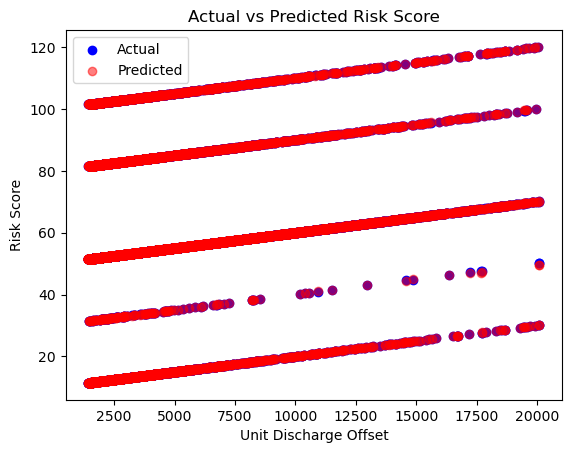

In [47]:
import matplotlib.pyplot as plt

plt.scatter(X_test['unitdischargeoffset'], y_test, color='blue', label='Actual')
plt.scatter(X_test['unitdischargeoffset'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.xlabel('Unit Discharge Offset')
plt.ylabel('Risk Score')
plt.title('Actual vs Predicted Risk Score')
plt.legend()
plt.show()

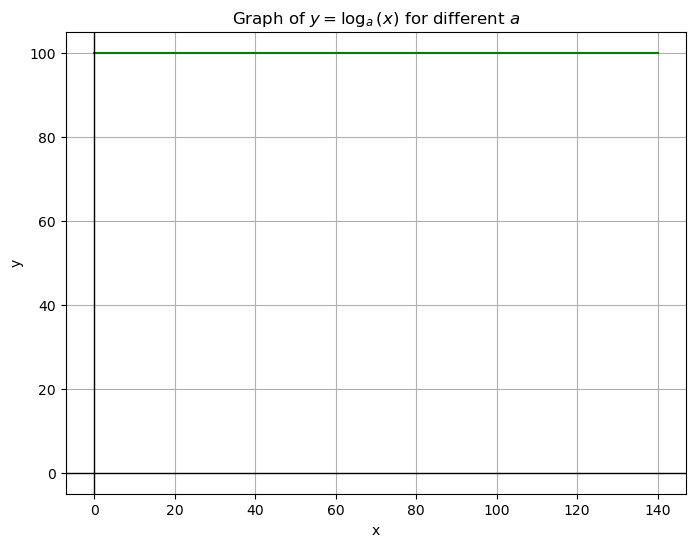

In [44]:
x = np.linspace(0, 1440*14, 500) 

offset=1000
y_a=100 - np.exp(-0.0009 * (1440*14-x)) * 100 

plt.figure(figsize=(8, 6))


plt.plot( x,y_a, color='green', label=r'risk score')

plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.title(r'Graph of $y=\log_a(x)$ for different $a$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [13]:

# 定义 risk score 函数
def calculate_risk_score(discharge_risk_category, offset):
    # 高风险的出院地点
    if discharge_risk_category == 'Death':
        return 100 - np.exp(-0.01 * offset) * 100  # 越接近出院，风险越高
    # 中高风险的出院地点
    elif discharge_risk_category == 'High Risk':
        return 80 - np.exp(-0.005 * offset) * 80
     # 中风险的出院地点
    elif discharge_risk_category =='Medium Risk':
        return 70 - np.exp(-0.005 * offset) * 80
    # 低风险的出院地点
    elif discharge_risk_category=='Low Risk':
        return 40 - np.exp(-0.002 * offset) * 50
    # 其他地点
    else:
        return 60 - np.exp(-0.003 * offset) * 60

# 应用到数据
df_p1['risk_score'] = df_p1.apply(lambda row: calculate_risk_score(row['discharge_risk_category'], row['unitdischargeoffset']), axis=1)

# 查看结果
df_p1[['unitdischargelocation', 'unitdischargeoffset','discharge_risk_category','risk_score']].head()


,unitdischargelocation,unitdischargeoffset,discharge_risk_category,risk_score
0,Death,3596,Death,100.000000
1,Floor,6068,Medium Risk,70.000000
2,Floor,1501,Medium Risk,69.955974
3,Home,1684,Low Risk,38.277076
4,Floor,2076,Medium Risk,69.997516


In [16]:

# 对 unitdischargelocation 进行 Label Encoding
label_encoder = LabelEncoder()
df_p1['unitdischargelocation_encoded'] = label_encoder.fit_transform(df_p1['discharge_risk_category'])

# 检查编码结果
df_p1[['unitdischargelocation','discharge_risk_category', 'unitdischargelocation_encoded']].head()

,unitdischargelocation,discharge_risk_category,unitdischargelocation_encoded
0,Death,Death,0
1,Floor,Medium Risk,3
2,Floor,Medium Risk,3
3,Home,Low Risk,2
4,Floor,Medium Risk,3


Mean Squared Error: 4.69664890767996e-06


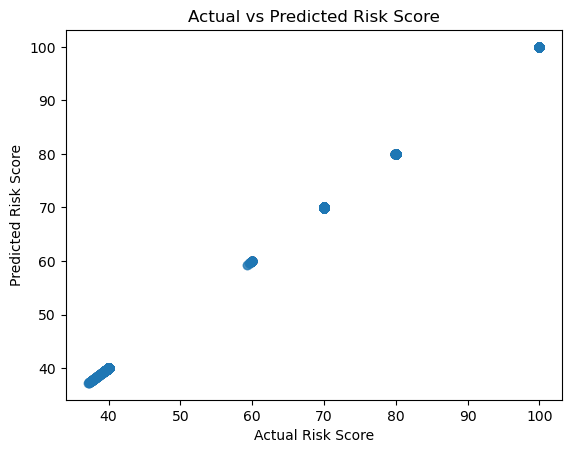

In [28]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X = df_p1[['unitdischargeoffset', 'unitdischargelocation_encoded']]
y = df_p1['risk_score']

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练模型
model = XGBRegressor()
model.fit(X_train, y_train)

# 预测并评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 查看部分预测结果
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Risk Score')
plt.ylabel('Predicted Risk Score')
plt.title('Actual vs Predicted Risk Score')
plt.show()

In [23]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, Dataset

# # 定义数据集类
# class RiskDataset(Dataset):
#     def __init__(self, df):
#         self.df = df

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         # 返回unitdischargeoffset, unitdischargelocation_encoded 作为输入
#         # 返回 risk_score 作为目标值
#         return (
#             torch.tensor(self.df.iloc[idx]['unitdischargeoffset'], dtype=torch.float),
#             torch.tensor(self.df.iloc[idx]['unitdischargelocation_encoded'], dtype=torch.long),
#             torch.tensor(self.df.iloc[idx]['risk_score'], dtype=torch.float)
#         )

# # 创建数据集
# dataset = RiskDataset(df_p1)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# # 定义 Transformer 模型
# class RiskTransformer(nn.Module):
#     def __init__(self, n_classes, d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=128):
#         super(RiskTransformer, self).__init__()
#         self.embedding = nn.Embedding(n_classes, d_model)  # 类别变量的嵌入
#         self.offset_fc = nn.Linear(1, d_model)  # 将 unitdischargeoffset 转换成与嵌入相同的维度
#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward),
#             num_layers=num_encoder_layers
#         )
#         self.fc = nn.Linear(d_model, 1)  # 输出层，预测风险分数

#     def forward(self, offset, location_encoded):
#         # 对 location 进行嵌入
#         embedded_location = self.embedding(location_encoded)  # 类别型变量的嵌入
        
#         # 将 unitdischargeoffset 通过全连接层映射到与嵌入相同的维度
#         offset_transformed = self.offset_fc(offset.unsqueeze(1))  # offset 是一维的，需要增加一个维度
        
#         # 确保两者维度一致后，进行拼接
#         x = offset_transformed + embedded_location  # 注意这里改为相加，保持嵌入后的维度一致
        
#         # 传入 Transformer Encoder
#         x = self.transformer_encoder(x.unsqueeze(1))  # 加上额外的维度，符合 Transformer 输入要求
        
#         # 使用最后一个位置的输出预测风险分数
#         x = self.fc(x[:, -1, :])  
#         return x

    

# # 定义模型参数
# n_classes = df_p1['unitdischargelocation_encoded'].nunique()  # 确认类别的数量
# model = RiskTransformer(n_classes)

# # 定义损失函数和优化器
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # 训练模型
# epochs = 10
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for offset, location_encoded, target in dataloader:
#         optimizer.zero_grad()
#         outputs = model(offset, location_encoded)
#         loss = criterion(outputs.squeeze(), target)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")


Epoch 1, Loss: 561.3166986209536
Epoch 2, Loss: 165.81405984669883
Epoch 3, Loss: 166.01055739367882
Epoch 4, Loss: 165.9458045141337
Epoch 5, Loss: 165.99680006643388
Epoch 6, Loss: 166.0230476300033
Epoch 7, Loss: 166.01264536787608
Epoch 8, Loss: 166.019110123205
Epoch 9, Loss: 166.06535906611117
Epoch 10, Loss: 166.0015618305108
